# Practical PyTorch: Generating Names with a Character-Level RNN

The previous tutorial we used a RNN to classify names into languages. This time we'll turn around and generate names from languages. The model is still a simple RNN, with one extra layer.

```
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb)
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)

It would also be useful to know a bit about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

# Preparing the Data

See "Classifying Names with a Character-Level RNN" for specifics on loading the data from the names files.

In [1]:
import glob
import unicodedata
import string

all_letters = string.ascii_letters
n_letters = len(all_letters) + 1 # Plus EOS marker

filenames = glob.glob('../data/names/*.txt')

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def stripAccents(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readNames(filename):
    names = open(filename).read().strip().split('\n')
    return [stripAccents(name) for name in names]

# Build the lang_names dictionary, a list of names per language
lang_names = {}
all_langs = []

for filename in filenames:
    lang = filename.split('/')[-1].split('.')[0]
    all_langs.append(lang)
    names = readNames(filename)
    lang_names[lang] = names

n_langs = len(all_langs)

print('n langs:', n_langs)
print('all langs:', all_langs)
print(stripAccents("O'Neal"))

n langs: 18
all langs: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
ONeal


# Creating the Network

This network is similar to [the last tutorial](#Creating-the-Network) but has an extra output layer, which combines both the hidden and other output as input, and a dropout layer before the softmax to increase variety of outputs.

![](https://i.imgur.com/V0pwTrm.png)

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_langs + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_langs + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, lang, input, hidden):
        input_combined = torch.cat((lang, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

# Preparing for Training

Here we define a bunch of helper functions to 

In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Create training pair (lang, name)
def randomTrainingPair():
    lang = randomChoice(all_langs)
    name = randomChoice(lang_names[lang])
    return lang, name

# One-hot tensor for language
def langTensor(lang):
    li = all_langs.index(lang)
    tensor = torch.zeros(1, n_langs)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to 2nd-to-last letters for input
def inputTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li in range(len(name)):
        letter = name[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# One-hot matrix of second to last letters for target
def targetTensor(name):
    letter_indexes = [all_letters.find(name[li]) for li in range(1, len(name))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make language, input, and target tensors from a random language, name pair
def randomTrainingTensors():
    lang, name = randomTrainingPair()
    lang_tensor = Variable(langTensor(lang))
    input_name_tensor = Variable(inputTensor(name))
    target_name_tensor = Variable(targetTensor(name))
    return lang_tensor, input_name_tensor, target_name_tensor

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step (the next letter to output). The loss output can simply be added at every step (don't ask me how adding to 0 works, but it ends up as a Tensor), and then we call backward at the end.

In [4]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(target_lang, input_name, target_name):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    loss = 0
    
    for i in range(len(input_name)):
        output, hidden = rnn(target_lang, input_name[i], hidden)
        loss += criterion(output, target_name[i])
        
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / len(input_name)

In [5]:
import time
import math

rnn = RNN(n_letters, 128, n_letters)

n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

for epoch in range(1, n_epochs + 1):
    output, loss = train(*randomTrainingTensors())
    total_loss += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_epochs * 100, loss))
    
    if epoch % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 3.3737
0m 25s (10000 10%) 2.0563
0m 37s (15000 15%) 2.7080
0m 50s (20000 20%) 2.1657
1m 3s (25000 25%) 2.5592
1m 16s (30000 30%) 2.5187
1m 29s (35000 35%) 2.8077
1m 41s (40000 40%) 2.2148
1m 54s (45000 45%) 2.0617
2m 7s (50000 50%) 2.1282
2m 19s (55000 55%) 1.8835
2m 33s (60000 60%) 2.8455
2m 45s (65000 65%) 2.0836
2m 58s (70000 70%) 3.1872
3m 10s (75000 75%) 2.7852
3m 23s (80000 80%) 3.7852
3m 36s (85000 85%) 2.6365
3m 48s (90000 90%) 2.6528
4m 2s (95000 95%) 2.7486
4m 14s (100000 100%) 2.2250


# Plotting the Network

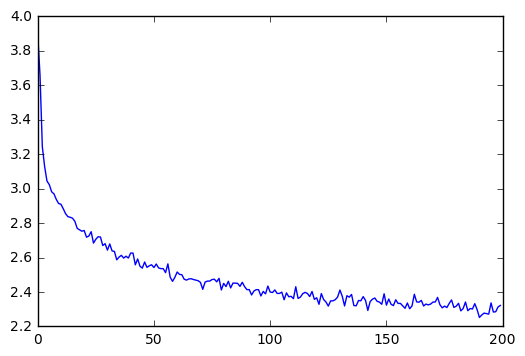

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token. Another strategy would have been to include a "start of string" token in training and start from there.

In [7]:
def sample(target_lang, start_letter='A'):
    target_lang = Variable(langTensor(target_lang))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter
    
    for i in range(10):
        output, hidden = rnn(target_lang, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:    
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

def samples(target_lang, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(target_lang, start_letter))

In [8]:
samples('Russian', 'RUS')

Roukan
Uariski
Shavaki


In [9]:
samples('German', 'GER')

Garen
Eren
Roure


In [10]:
samples('Spanish', 'SPA')

Sallan
Parer
Alaner


In [11]:
samples('Chinese', 'CHI')

Chan
Hang
Iun


# Exercises

* Use random sampling (rather than top 1) to output a variety of names when sampling.
* Use a "start of sentence" token so that sampling can be done without extra input.
* Extend the network to more layers, or use a proven shape like LSTM or GRU.